# Atmospheric Precipitation, Temperature, and Cloudiness forecAST (APTCAST)

This notebook is the main notebook for the temperature aspect of the APTCAST project - forecasting atmospheric phenomena. Specific forecasted phenomena include precipitation, temperature and cloudiness. Each of these notebooks follow the same process:

1. Data Description
2. Libraries
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Non-ML Forecasting
6. ML Forecasting (stretch)

Due to compute limitations non-ML methods will the main focus of the forecasting. ML forecasting will be implemented after non-ML forecasting techniques are tested, as the non-ML forecasting can be used as a starting point for the ML predictions. 

## Data Description

The data for this project is the data retrieved from the National Oceanic and Atmospheric Administration's (NOAA) National Centers for Environmental Information (NCEI). NCEI has a tool, the climate data online (CDO), that allows for retrieving from an archive of global historical weather. In [CDO's geospatial data repository](https://www.ncei.noaa.gov/maps-and-geospatial-products), local climatological data can be ordered. For the scope of this project, Maui will be the focus of our forecasts. Only Kahului airport has a full non-null dataset between the dry bulb temperature, so Kahului airport's data will be used. Records go all the way back to 1996.

## Libraries

Libraries used in this notebook are shown in the imports below. Throughout this project, initial goal was to gain experience in forecasting as well as the polars library, so polars is used instead of pandas.

Statsmodels is another library I ended up employing that I have not used prior.

In [1]:
import numpy as np
import polars as pl
import itertools
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import torch
import torch.nn as nn

## EDA

In the EDA for this project, statistical methods will be used to find correlations within the data and find important relationships between fields, as well data cleaning.

### Loading Data

Data is loaded using polars and individual csvs retrieved from CDO are concatenated.

In [2]:
lf_1996 = pl.scan_csv("data/1996to2005.csv", ignore_errors=True).select("DATE", "DailyAverageDryBulbTemperature").drop_nulls()
lf_2015 = pl.scan_csv("data/2005to2015.csv", ignore_errors=True).select("DATE", "DailyAverageDryBulbTemperature").drop_nulls()
lf_2025 = pl.scan_csv("data/2015to2025.csv", ignore_errors=True).select("DATE", "DailyAverageDryBulbTemperature").drop_nulls()

In [3]:
lf_1996 = lf_1996.with_columns(
    pl.col("DailyAverageDryBulbTemperature").str.replace_all(r"[^0-9]", "").cast(pl.Int64).alias("TEMP")
)

lf_1996 = lf_1996.drop("DailyAverageDryBulbTemperature")

lf_2015 = lf_2015.rename({"DailyAverageDryBulbTemperature": "TEMP"})

lf_2025 = lf_2025.rename({"DailyAverageDryBulbTemperature": "TEMP"})

lf_full = pl.concat([lf_1996, lf_2015, lf_2025], how="vertical")

lf_full.collect()

DATE,TEMP
str,i64
"""1996-07-01T23:59:00""",83
"""1996-07-02T23:59:00""",83
"""1996-07-03T23:59:00""",82
"""1996-07-04T23:59:00""",79
"""1996-07-05T23:59:00""",80
…,…
"""2025-07-06T23:59:00""",81
"""2025-07-07T23:59:00""",80
"""2025-07-08T23:59:00""",80


### Outlier Removal

Visual inspection of data is used to find outliers within the data, and outliers are promptly removed due to model sensitivities to outliers.

In [4]:
lf_full.describe()

statistic,DATE,TEMP
str,str,f64
"""count""","""10332""",10332.0
"""null_count""","""0""",0.0
"""mean""",null,76.633082
"""std""",null,3.694641
"""min""","""1996-07-01T23:59:00""",50.0
"""25%""",null,74.0
"""50%""",null,77.0
"""75%""",null,79.0
"""max""","""2025-07-10T23:59:00""",86.0


In [5]:
intervals = lf_full.select("DATE").filter(pl.col("DATE").str.starts_with("1996-07-01") | pl.col("DATE").str.starts_with("2000-01-01") | pl.col("DATE").str.starts_with("2005-01-01") | pl.col("DATE").str.starts_with("2010-01-01") | pl.col("DATE").str.starts_with("2015-01-01") | pl.col("DATE").str.starts_with("2020-01-01") | pl.col("DATE").str.starts_with("2025-01-01")).collect().to_series()
intervals

DATE
str
"""1996-07-01T23:59:00"""
"""2000-01-01T23:59:00"""
"""2005-01-01T23:59:00"""
"""2010-01-01T23:59:00"""
"""2015-01-01T23:59:00"""
"""2020-01-01T23:59:00"""
"""2025-01-01T23:59:00"""


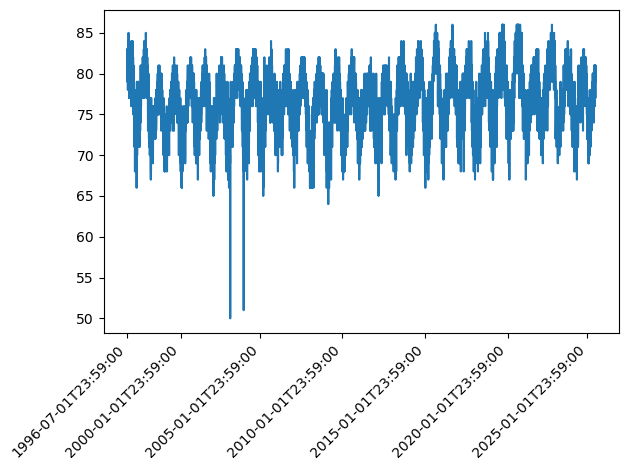

In [6]:
plt.plot(lf_full.select("DATE").collect().to_series(), lf_full.select("TEMP").collect().to_series())
plt.xticks(intervals, rotation=45, ha="right")
plt.tight_layout()

plt.show()

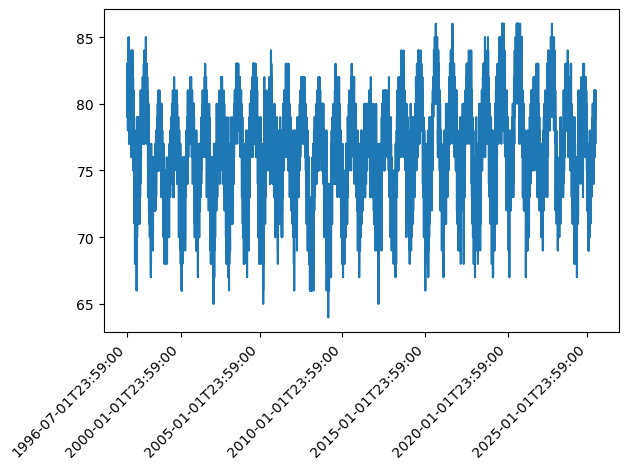

In [7]:
lf_full = lf_full.filter(pl.col("TEMP") > 55)
plt.plot(lf_full.select("DATE").collect().to_series(), lf_full.select("TEMP").collect().to_series())
plt.xticks(intervals, rotation=45, ha="right")
plt.tight_layout()

plt.show()

In [8]:
lf_full.describe()

statistic,DATE,TEMP
str,str,f64
"""count""","""10330""",10330.0
"""null_count""","""0""",0.0
"""mean""",null,76.638141
"""std""",null,3.677051
"""min""","""1996-07-01T23:59:00""",64.0
"""25%""",null,74.0
"""50%""",null,77.0
"""75%""",null,79.0
"""max""","""2025-07-10T23:59:00""",86.0


### Autocorrelation

The correlation of lags should be inspected for forecasting. Since there is seasonality in this data, both autocorrelation will be shown as well as partial autocorrelation to find both seasonality strength and optimal lags.

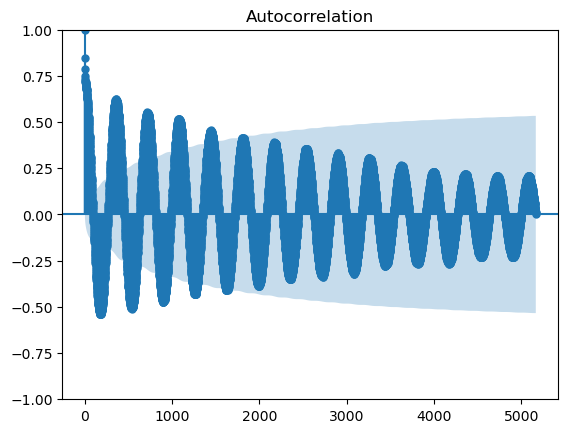

In [9]:
plot_acf(lf_full.select("TEMP").collect().to_series(), lags=len(lf_full.select("TEMP").collect().to_series()) // 2)
plt.show()

Seasonality is confirmed in the autocorrelation plot. It's also shown that there is some trend to the data, since correlation decreases after each period.

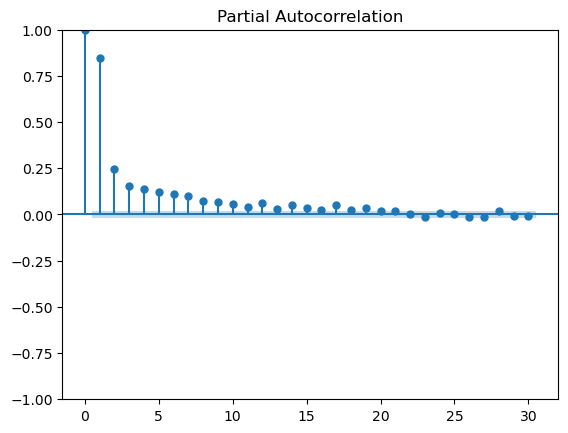

In [10]:
plot_pacf(lf_full.select("TEMP").collect().to_series(), lags=30)
plt.show()

Optimal lags up to 9 (0-9) will be tested in ARIMA model later, since autocorrelation is relatively low after that point.

## Feature Engineering

Easily ingestible fields can be engineered from the two current fields (DATE and TEMP)

### Date Fields

Time based fields can be extracted from the timestamps in the "DATE" column.

In [11]:
date_str = lf_full.select("DATE").collect().to_series().str.to_datetime("%Y-%m-%dT%H:%M:%S").dt

lf_full = lf_full.with_columns(
    date_str.year().alias("YEAR"),
    date_str.month().alias("MONTH"),
    date_str.day().alias("DAY"),
    date_str.hour().alias("HOUR"),
    date_str.minute().alias("MINUTE"),
    date_str.second().alias("SECOND")
    
)

lf_full.collect()

DATE,TEMP,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND
str,i64,i32,i8,i8,i8,i8,i8
"""1996-07-01T23:59:00""",83,1996,7,1,23,59,0
"""1996-07-02T23:59:00""",83,1996,7,2,23,59,0
"""1996-07-03T23:59:00""",82,1996,7,3,23,59,0
"""1996-07-04T23:59:00""",79,1996,7,4,23,59,0
"""1996-07-05T23:59:00""",80,1996,7,5,23,59,0
…,…,…,…,…,…,…,…
"""2025-07-06T23:59:00""",81,2025,7,6,23,59,0
"""2025-07-07T23:59:00""",80,2025,7,7,23,59,0
"""2025-07-08T23:59:00""",80,2025,7,8,23,59,0


In [12]:
lf_full = lf_full.select(["DATE", "YEAR", "MONTH", "DAY", "HOUR", "MINUTE", "SECOND", "TEMP"])
lf_full = lf_full.with_row_index()
lf_full.collect()

index,DATE,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,TEMP
u32,str,i32,i8,i8,i8,i8,i8,i64
0,"""1996-07-01T23:59:00""",1996,7,1,23,59,0,83
1,"""1996-07-02T23:59:00""",1996,7,2,23,59,0,83
2,"""1996-07-03T23:59:00""",1996,7,3,23,59,0,82
3,"""1996-07-04T23:59:00""",1996,7,4,23,59,0,79
4,"""1996-07-05T23:59:00""",1996,7,5,23,59,0,80
…,…,…,…,…,…,…,…,…
10325,"""2025-07-06T23:59:00""",2025,7,6,23,59,0,81
10326,"""2025-07-07T23:59:00""",2025,7,7,23,59,0,80
10327,"""2025-07-08T23:59:00""",2025,7,8,23,59,0,80


In [13]:
corr_schema = lf_full.drop("DATE").collect_schema()

for column in corr_schema.names():

    corr = lf_full.drop("DATE").select(pl.corr(column, "TEMP")).collect().item()
    print(f"{column}: {corr}") 

index: 0.14148376892383874
YEAR: 0.12538976446137035
MONTH: 0.42324397795515983
DAY: 0.015917693115134406
HOUR: nan
MINUTE: nan
SECOND: nan
TEMP: 1.0


Correlations for the date fields are shown - month having a higher correlation makes sense since temperature will change as the year goes on, but year by year they'll only change slightly. Hour, Minute, and Second are all nan since each record is at 23:59 each day.

### Seasons

As shown above, the month field has a relatively high correlation. This could also mean that seasons have a high correlation.

In [14]:
lf_full = lf_full.with_columns(
    pl.when((pl.col("MONTH") >= 3) & (pl.col("MONTH") <= 5)).then(3)
    .when((pl.col("MONTH") >= 6) & (pl.col("MONTH") <= 8)).then(2)
    .when((pl.col("MONTH") >= 9) & (pl.col("MONTH") <= 11)).then(1)
    .otherwise(0).alias("SEASON")
)
lf_full = lf_full.select(["index", "DATE", "YEAR", "SEASON", "MONTH", "DAY", "HOUR", "MINUTE", "SECOND", "TEMP"])

In [15]:
corr_schema = lf_full.drop("DATE").collect_schema()

for column in corr_schema.names():

    corr = lf_full.drop("DATE").select(pl.corr(column, "TEMP")).collect().item()
    print(f"{column}: {corr}") 

index: 0.14148376892383874
YEAR: 0.12538976446137035
SEASON: 0.21422565514481115
MONTH: 0.42324397795515983
DAY: 0.015917693115134406
HOUR: nan
MINUTE: nan
SECOND: nan
TEMP: 1.0


Relatively high correlation with normal seasons; however, since data is in Hawaii more granular field may be more useful. Specific solstice and equinox dates and times each year can be used to make it more granular.

In [16]:
soleq_lf = pl.scan_csv("data/solsticeequinox_hst.csv")
soleq_lf.collect()

YEAR,SPRING_DT,SUMMER_DT,AUTUMN_DT,WINTER_DT
i64,str,str,str,str
1996,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
1997,"""1997-03-20T03:54:00""","""1997-06-20T03:54:00""","""1997-09-22T13:55:00""","""1997-12-21T10:07:00"""
1998,"""1998-03-20T09:54:00""","""1998-06-21T04:02:00""","""1998-09-22T19:37:00""","""1998-12-21T15:56:00"""
1999,"""1999-03-20T15:46:00""","""1999-06-21T09:49:00""","""1999-09-23T01:31:00""","""1999-12-21T21:44:00"""
2000,"""2000-03-19T21:35:00""","""2000-06-20T15:47:00""","""2000-09-22T07:27:00""","""2000-12-21T03:37:00"""
…,…,…,…,…
2026,"""2026-03-20T04:45:00""","""2026-06-20T22:25:00""","""2026-09-22T14:05:00""","""2026-12-21T10:50:00"""
2027,"""2027-03-20T10:24:00""","""2027-06-21T04:10:00""","""2027-09-22T20:01:00""","""2027-12-21T16:42:00"""
2028,"""2028-03-19T16:17:00""","""2028-06-20T10:01:00""","""2028-09-22T01:45:00""","""2028-12-20T22:20:00"""


In [17]:
lf_full = lf_full.join(soleq_lf, on="YEAR", how='left')
lf_full.collect()

index,DATE,YEAR,SEASON,MONTH,DAY,HOUR,MINUTE,SECOND,TEMP,SPRING_DT,SUMMER_DT,AUTUMN_DT,WINTER_DT
u32,str,i32,i32,i8,i8,i8,i8,i8,i64,str,str,str,str
0,"""1996-07-01T23:59:00""",1996,2,7,1,23,59,0,83,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
1,"""1996-07-02T23:59:00""",1996,2,7,2,23,59,0,83,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
2,"""1996-07-03T23:59:00""",1996,2,7,3,23,59,0,82,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
3,"""1996-07-04T23:59:00""",1996,2,7,4,23,59,0,79,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
4,"""1996-07-05T23:59:00""",1996,2,7,5,23,59,0,80,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
10325,"""2025-07-06T23:59:00""",2025,2,7,6,23,59,0,81,"""2025-03-19T23:01:00""","""2025-06-20T16:42:00""","""2025-09-22T08:19:00""","""2025-12-21T05:03:00"""
10326,"""2025-07-07T23:59:00""",2025,2,7,7,23,59,0,80,"""2025-03-19T23:01:00""","""2025-06-20T16:42:00""","""2025-09-22T08:19:00""","""2025-12-21T05:03:00"""
10327,"""2025-07-08T23:59:00""",2025,2,7,8,23,59,0,80,"""2025-03-19T23:01:00""","""2025-06-20T16:42:00""","""2025-09-22T08:19:00""","""2025-12-21T05:03:00"""


In [18]:
lf_full = lf_full.with_columns(

    pl.col("DATE").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("DATE"),
    pl.col("SPRING_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("SPRING_DT"),
    pl.col("SUMMER_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("SUMMER_DT"),
    pl.col("AUTUMN_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("AUTUMN_DT"),
    pl.col("WINTER_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("WINTER_DT")
    
)
lf_full.collect()

index,DATE,YEAR,SEASON,MONTH,DAY,HOUR,MINUTE,SECOND,TEMP,SPRING_DT,SUMMER_DT,AUTUMN_DT,WINTER_DT
u32,datetime[μs],i32,i32,i8,i8,i8,i8,i8,i64,datetime[μs],datetime[μs],datetime[μs],datetime[μs]
0,1996-07-01 23:59:00,1996,2,7,1,23,59,0,83,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
1,1996-07-02 23:59:00,1996,2,7,2,23,59,0,83,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
2,1996-07-03 23:59:00,1996,2,7,3,23,59,0,82,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
3,1996-07-04 23:59:00,1996,2,7,4,23,59,0,79,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
4,1996-07-05 23:59:00,1996,2,7,5,23,59,0,80,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…
10325,2025-07-06 23:59:00,2025,2,7,6,23,59,0,81,2025-03-19 23:01:00,2025-06-20 16:42:00,2025-09-22 08:19:00,2025-12-21 05:03:00
10326,2025-07-07 23:59:00,2025,2,7,7,23,59,0,80,2025-03-19 23:01:00,2025-06-20 16:42:00,2025-09-22 08:19:00,2025-12-21 05:03:00
10327,2025-07-08 23:59:00,2025,2,7,8,23,59,0,80,2025-03-19 23:01:00,2025-06-20 16:42:00,2025-09-22 08:19:00,2025-12-21 05:03:00


In [19]:
lf_full = lf_full.with_columns(

    pl.when((pl.col("DATE") >= pl.col("SPRING_DT")) & (pl.col("DATE") <= pl.col("SUMMER_DT"))).then(3)
        .when((pl.col("DATE") >= pl.col("SUMMER_DT")) & (pl.col("DATE") <= pl.col("AUTUMN_DT"))).then(2)
        .when((pl.col("DATE") >= pl.col("AUTUMN_DT")) & (pl.col("DATE") <= pl.col("WINTER_DT"))).then(1)    
        .when((pl.col("DATE") >= pl.col("WINTER_DT")) | (pl.col("DATE") <= pl.col("SPRING_DT"))).then(0).alias("SOLSTICE_SEASON"),
)

In [20]:
lf_full = lf_full.select(["index", "YEAR", "SEASON", "SOLSTICE_SEASON", "MONTH", "DAY", "TEMP"])

In [21]:
corr_schema = lf_full.collect_schema()

for column in corr_schema.names():

    corr = lf_full.select(pl.corr(column, "TEMP")).collect().item()
    print(f"{column}: {corr}") 

index: 0.1414837689238311
YEAR: 0.12538976446137035
SEASON: 0.21422565514481115
SOLSTICE_SEASON: 0.39398672183435746
MONTH: 0.42324397795515983
DAY: 0.015917693115134406
TEMP: 1.0


### Encoding

Fields must be encoded to be ingested correctly in ML models. Seasonal fields are encoded with sinusoidal encoding, and other numerical fields are normalized. Temp is separated from all other variables to become the target.

In [22]:
min_year = 1996
max_year = 2028

lf_full = lf_full.with_columns(

    ((pl.col("YEAR") - min_year) / (max_year - min_year)).alias("YEAR"),
    pl.when(pl.col("SOLSTICE_SEASON") == 3).then(1).otherwise(0).alias("SPRING"),
    pl.when(pl.col("SOLSTICE_SEASON") == 2).then(1).otherwise(0).alias("SUMMER"),
    pl.when(pl.col("SOLSTICE_SEASON") == 1).then(1).otherwise(0).alias("AUTUMN"),
    pl.when(pl.col("SOLSTICE_SEASON") == 0).then(1).otherwise(0).alias("WINTER"),
    np.sin(2 * np.pi * ((pl.col("MONTH") - 1) / 11)).alias("MONTH_SIN"),
    np.cos(2 * np.pi * ((pl.col("MONTH") - 1) / 11)).alias("MONTH_COS"),
    np.sin(2 * np.pi * ((pl.col("DAY") - 1) / 30)).alias("DAY_SIN"),
    np.cos(2 * np.pi * ((pl.col("DAY") - 1) / 30)).alias("DAY_COS"), 
    pl.col("TEMP").shift(-1).alias("TEMP_t-1"),
    pl.col("TEMP").shift(-2).alias("TEMP_t-2"),
    pl.col("TEMP").shift(-3).alias("TEMP_t-3"),
    pl.col("TEMP").shift(-4).alias("TEMP_t-4"),
    pl.col("TEMP").shift(-5).alias("TEMP_t-5"),
    pl.col("TEMP").shift(-6).alias("TEMP_t-6"),
    pl.col("TEMP").shift(-7).alias("TEMP_t-7"),
    pl.col("TEMP").shift(-8).alias("TEMP_t-8"),
    pl.col("TEMP").shift(-9).alias("TEMP_t-9"),
    pl.col("TEMP").shift(-10).alias("TEMP_t-10"),
    pl.col("TEMP").shift(-11).alias("TEMP_t-11"),
    pl.col("TEMP").shift(-12).alias("TEMP_t-12"),
    pl.col("TEMP").shift(-13).alias("TEMP_t-13"),
    pl.col("TEMP").shift(-14).alias("TEMP_t-14"),
    pl.col("TEMP").shift(-15).alias("TEMP_t-15"),
    
)

lf_full = lf_full.with_columns(

    ((pl.col("MONTH_SIN") - pl.col("MONTH_SIN").min()) / (pl.col("MONTH_SIN").max() - pl.col("MONTH_SIN").min())).alias("MONTH_SIN"),
    ((pl.col("MONTH_COS") - pl.col("MONTH_COS").min()) / (pl.col("MONTH_COS").max() - pl.col("MONTH_COS").min())).alias("MONTH_COS"),
    ((pl.col("DAY_SIN") - pl.col("DAY_SIN").min()) / (pl.col("DAY_SIN").max() - pl.col("DAY_SIN").min())).alias("DAY_SIN"),
    ((pl.col("DAY_COS") - pl.col("DAY_COS").min()) / (pl.col("DAY_COS").max() - pl.col("DAY_COS").min())).alias("DAY_COS"),
    ((pl.col("TEMP_t-1") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-1"),
    ((pl.col("TEMP_t-2") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-2"),
    ((pl.col("TEMP_t-3") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-3"),
    ((pl.col("TEMP_t-4") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-4"),
    ((pl.col("TEMP_t-5") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-5"),
    ((pl.col("TEMP_t-6") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-6"),
    ((pl.col("TEMP_t-7") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-7"),
    ((pl.col("TEMP_t-8") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-8"),
    ((pl.col("TEMP_t-9") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-9"),
    ((pl.col("TEMP_t-10") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-10"),
    ((pl.col("TEMP_t-11") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-11"),
    ((pl.col("TEMP_t-12") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-12"),
    ((pl.col("TEMP_t-13") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-13"),
    ((pl.col("TEMP_t-14") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-14"),
    ((pl.col("TEMP_t-15") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-15"),
)

In [23]:
lf_full = lf_full.drop_nulls().filter(pl.col("YEAR") >= 0)
y = lf_full.select(["index", "TEMP"])
X = lf_full.sort("index").drop(["MONTH", "DAY", "TEMP"])
X.collect()

index,YEAR,SEASON,SOLSTICE_SEASON,SPRING,SUMMER,AUTUMN,WINTER,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,TEMP_t-1,TEMP_t-2,TEMP_t-3,TEMP_t-4,TEMP_t-5,TEMP_t-6,TEMP_t-7,TEMP_t-8,TEMP_t-9,TEMP_t-10,TEMP_t-11,TEMP_t-12,TEMP_t-13,TEMP_t-14,TEMP_t-15
u32,f64,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.0,2,2,0,1,0,0,0.357685,0.0,0.5,1.0,0.863636,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727
1,0.0,2,2,0,1,0,0,0.357685,0.0,0.604528,0.989074,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727
2,0.0,2,2,0,1,0,0,0.357685,0.0,0.704489,0.956773,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727
3,0.0,2,2,0,1,0,0,0.357685,0.0,0.795511,0.904508,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727,0.772727
4,0.0,2,2,0,1,0,0,0.357685,0.0,0.873619,0.834565,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727,0.772727,0.818182
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
10310,0.90625,2,2,0,1,0,0,0.642315,5.6659e-17,0.126381,0.165435,0.727273,0.772727,0.681818,0.727273,0.772727,0.772727,0.681818,0.772727,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727
10311,0.90625,2,2,0,1,0,0,0.642315,5.6659e-17,0.064602,0.25,0.772727,0.681818,0.727273,0.772727,0.772727,0.681818,0.772727,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273
10312,0.90625,2,2,0,1,0,0,0.642315,5.6659e-17,0.021852,0.345492,0.681818,0.727273,0.772727,0.772727,0.681818,0.772727,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273,0.727273


### Train/Test Split

Final year (2024-2025) is used as the test set, and everything before is the training set. Since 2025 is not finished yet, test set will not be the entire year.

In [24]:
final_index = X.select(pl.len()).collect().item()
final_year_start = final_index - 356
X_test = X.filter(pl.col("index") >= final_year_start)
X_test.collect()

index,YEAR,SEASON,SOLSTICE_SEASON,SPRING,SUMMER,AUTUMN,WINTER,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,TEMP_t-1,TEMP_t-2,TEMP_t-3,TEMP_t-4,TEMP_t-5,TEMP_t-6,TEMP_t-7,TEMP_t-8,TEMP_t-9,TEMP_t-10,TEMP_t-11,TEMP_t-12,TEMP_t-13,TEMP_t-14,TEMP_t-15
u32,f64,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
9959,0.875,3,3,1,0,0,0,0.881761,0.155465,0.126381,0.834565,0.727273,0.590909,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909,0.590909,0.636364,0.727273,0.727273
9960,0.875,3,3,1,0,0,0,0.881761,0.155465,0.204489,0.904508,0.590909,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909,0.590909,0.636364,0.727273,0.727273,0.681818
9961,0.875,3,3,1,0,0,0,0.881761,0.155465,0.295511,0.956773,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909,0.590909,0.636364,0.727273,0.727273,0.681818,0.681818
9962,0.875,3,3,1,0,0,0,0.881761,0.155465,0.395472,0.989074,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909,0.590909,0.636364,0.727273,0.727273,0.681818,0.681818,0.727273
9963,0.875,3,3,1,0,0,0,0.881761,0.155465,0.5,1.0,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909,0.590909,0.636364,0.727273,0.727273,0.681818,0.681818,0.727273,0.727273
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
10310,0.90625,2,2,0,1,0,0,0.642315,5.6659e-17,0.126381,0.165435,0.727273,0.772727,0.681818,0.727273,0.772727,0.772727,0.681818,0.772727,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727
10311,0.90625,2,2,0,1,0,0,0.642315,5.6659e-17,0.064602,0.25,0.772727,0.681818,0.727273,0.772727,0.772727,0.681818,0.772727,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273
10312,0.90625,2,2,0,1,0,0,0.642315,5.6659e-17,0.021852,0.345492,0.681818,0.727273,0.772727,0.772727,0.681818,0.772727,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273,0.727273


In [25]:
y_test = y.filter(pl.col("index").is_in(X_test.select("index").collect().to_series().to_list()))
y_test.collect()

index,TEMP
u32,i64
9959,77
9960,80
9961,77
9962,77
9963,77
…,…
10310,76
10311,80
10312,81


In [26]:
X_train = X.filter(~pl.col("index").is_in(X_test.select("index").collect().to_series().to_list()))
X_train.collect()

index,YEAR,SEASON,SOLSTICE_SEASON,SPRING,SUMMER,AUTUMN,WINTER,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,TEMP_t-1,TEMP_t-2,TEMP_t-3,TEMP_t-4,TEMP_t-5,TEMP_t-6,TEMP_t-7,TEMP_t-8,TEMP_t-9,TEMP_t-10,TEMP_t-11,TEMP_t-12,TEMP_t-13,TEMP_t-14,TEMP_t-15
u32,f64,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.0,2,2,0,1,0,0,0.357685,0.0,0.5,1.0,0.863636,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727
1,0.0,2,2,0,1,0,0,0.357685,0.0,0.604528,0.989074,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727
2,0.0,2,2,0,1,0,0,0.357685,0.0,0.704489,0.956773,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727
3,0.0,2,2,0,1,0,0,0.357685,0.0,0.795511,0.904508,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727,0.772727
4,0.0,2,2,0,1,0,0,0.357685,0.0,0.873619,0.834565,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727,0.772727,0.818182
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
9954,0.875,3,3,1,0,0,0,0.881761,0.155465,0.021852,0.345492,0.681818,0.681818,0.636364,0.590909,0.590909,0.727273,0.590909,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364
9955,0.875,3,3,1,0,0,0,0.881761,0.155465,5.5817e-17,0.447736,0.681818,0.636364,0.590909,0.590909,0.727273,0.590909,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909
9956,0.875,3,3,1,0,0,0,0.881761,0.155465,0.0,0.552264,0.636364,0.590909,0.590909,0.727273,0.590909,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909,0.590909


In [27]:
y_train = y.filter(pl.col("index").is_in(X_train.select("index").collect().to_series().to_list()))
y_train.collect()

index,TEMP
u32,i64
0,83
1,83
2,82
3,79
4,80
…,…
9954,77
9955,79
9956,79


## Non-ML Forecasting

From the autocorrelations, there is seasonality and trend in the data. SARIMA was tested; however, large runtimes prevent it from being used here. Instead, we can use statsmodels STLForecast, which breaks the data into trend and seasonality, and models the trend using ARIMA.

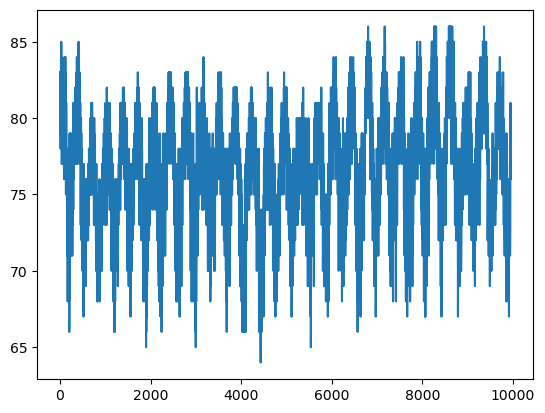

In [28]:
X_data = X_train.select("index").collect().to_series()
y_data = y_train.select("TEMP").collect().to_series()
plt.plot(X_data, y_data)

Since we have a large amount of training data for ARIMA models, we can use the AIC to identify which parameters to use through grid search.

In [29]:
p=q=range(0, 10)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
ARIMA = sm.tsa.arima.ARIMA
min_param = (0, 0, 0)
min_aic = float('inf')
sltf = sm.tsa.STLForecast(y_data, ARIMA, period=356)
for param in pdq:
    try:
        sltf = sm.tsa.STLForecast(y_data, ARIMA, model_kwargs=dict(order=param, trend='t'), period=356)
        sltf_fit = sltf.fit()
        aic = sltf_fit.model_result.aic
        min_param, min_aic = (param, aic) if aic < min_aic else (min_param, min_aic)
        print(f"{param}: {sltf_fit.model_result.aic}; Minimum aic - {min_param}: {min_aic} ")
    except ValueError as ve: 
        continue

(0, 0, 0): 100639.29323410784; Minimum aic - (0, 0, 0): 100639.29323410784 
(0, 0, 1): 87581.42656483897; Minimum aic - (0, 0, 1): 87581.42656483897 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyboardInterrupt: 

C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


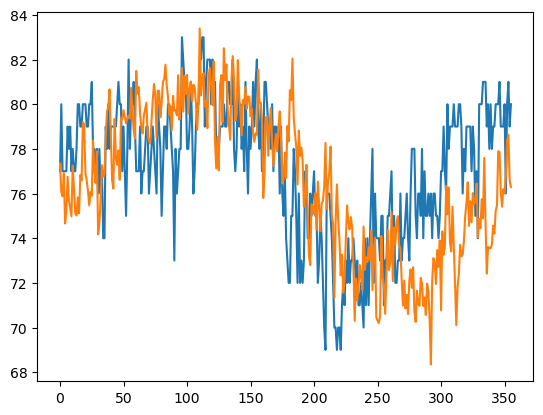

In [30]:
ARIMA = sm.tsa.arima.ARIMA
sltf = sm.tsa.STLForecast(y_data, ARIMA, model_kwargs=dict(order=(6, 1, 7), trend='t'), period=356)
sltf = sltf.fit()
forecast = sltf.forecast(y_test.select(pl.len()).collect().item())
plt.plot(y_test.select("TEMP").collect().to_series())
plt.plot(forecast)

In [31]:
mae_loss = mae(y_test.select("TEMP").collect().to_series(), forecast)
mse_loss = mse(y_test.select("TEMP").collect().to_series(), forecast)
train_mse = mse(y_train.select("TEMP").collect().to_series(), sltf.get_prediction(start=1, end=y_train.select(pl.len()).collect().item()).predicted_mean)
rmse_loss = np.sqrt(mse_loss)
print(f"MAE: {mae_loss}")
print(f"Training MSE: {train_mse}")
print(f"MSE: {mse_loss}")
print(f"RMSE: {rmse_loss}")

MAE: 2.5203713638219263
Training MSE: 1.8539407794556444
MSE: 9.818796191793416
RMSE: 3.1334958419939567


## ML Forecasting

From the non-ML forecasting, a RNN model could be created to mitigate some of the error from the STL model. Initial predictions will be the forecasts above. Development of the ML model will continue after precipitation and cloudiness notebooks. Loss function would be a average of mae and rmse.

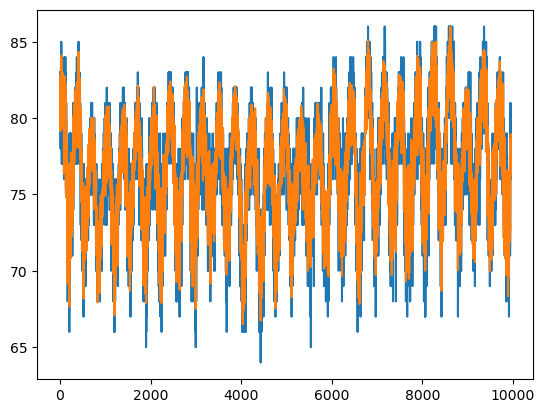

In [32]:
X_train = X_train.with_columns(
    pl.Series("PRIOR", sltf.get_prediction(start=1, end=y_train.select(pl.len()).collect().item()).predicted_mean)
)
plt.plot(y_train.select("TEMP").collect().to_series())
plt.plot(X_train.select("PRIOR").collect().to_series())

In [33]:
X_train.collect()

index,YEAR,SEASON,SOLSTICE_SEASON,SPRING,SUMMER,AUTUMN,WINTER,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,TEMP_t-1,TEMP_t-2,TEMP_t-3,TEMP_t-4,TEMP_t-5,TEMP_t-6,TEMP_t-7,TEMP_t-8,TEMP_t-9,TEMP_t-10,TEMP_t-11,TEMP_t-12,TEMP_t-13,TEMP_t-14,TEMP_t-15,PRIOR
u32,f64,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.0,2,2,0,1,0,0,0.357685,0.0,0.5,1.0,0.863636,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,82.252754
1,0.0,2,2,0,1,0,0,0.357685,0.0,0.604528,0.989074,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,81.775336
2,0.0,2,2,0,1,0,0,0.357685,0.0,0.704489,0.956773,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727,79.923631
3,0.0,2,2,0,1,0,0,0.357685,0.0,0.795511,0.904508,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727,0.772727,79.123827
4,0.0,2,2,0,1,0,0,0.357685,0.0,0.873619,0.834565,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727,0.772727,0.818182,80.728365
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
9954,0.875,3,3,1,0,0,0,0.881761,0.155465,0.021852,0.345492,0.681818,0.681818,0.636364,0.590909,0.590909,0.727273,0.590909,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,78.435275
9955,0.875,3,3,1,0,0,0,0.881761,0.155465,5.5817e-17,0.447736,0.681818,0.636364,0.590909,0.590909,0.727273,0.590909,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909,78.955718
9956,0.875,3,3,1,0,0,0,0.881761,0.155465,0.0,0.552264,0.636364,0.590909,0.590909,0.727273,0.590909,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909,0.590909,76.821509


In [34]:
X_train = X_train.with_columns(

    ((pl.col("PRIOR") - pl.col("PRIOR").min()) / (pl.col("PRIOR").max() - pl.col("PRIOR").min())).alias("PRIOR")
    
)
X_train = X_train.drop(["index", "SEASON", "SOLSTICE_SEASON"])
X_train.collect()

YEAR,SPRING,SUMMER,AUTUMN,WINTER,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,TEMP_t-1,TEMP_t-2,TEMP_t-3,TEMP_t-4,TEMP_t-5,TEMP_t-6,TEMP_t-7,TEMP_t-8,TEMP_t-9,TEMP_t-10,TEMP_t-11,TEMP_t-12,TEMP_t-13,TEMP_t-14,TEMP_t-15,PRIOR
f64,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0,1,0,0,0.357685,0.0,0.5,1.0,0.863636,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.80854
0.0,0,1,0,0,0.357685,0.0,0.604528,0.989074,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.784024
0.0,0,1,0,0,0.357685,0.0,0.704489,0.956773,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727,0.688938
0.0,0,1,0,0,0.357685,0.0,0.795511,0.904508,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727,0.772727,0.647867
0.0,0,1,0,0,0.357685,0.0,0.873619,0.834565,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727,0.636364,0.727273,0.772727,0.772727,0.772727,0.772727,0.818182,0.730261
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.875,1,0,0,0,0.881761,0.155465,0.021852,0.345492,0.681818,0.681818,0.636364,0.590909,0.590909,0.727273,0.590909,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.612509
0.875,1,0,0,0,0.881761,0.155465,5.5817e-17,0.447736,0.681818,0.636364,0.590909,0.590909,0.727273,0.590909,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909,0.639235
0.875,1,0,0,0,0.881761,0.155465,0.0,0.552264,0.636364,0.590909,0.590909,0.727273,0.590909,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909,0.590909,0.529641


In [35]:
class RNNForecast(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):

        super(RNNForecast, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x, hidden=None):

        out, hidden = self.rnn(x, hidden)
        print(out.shape)
        out = self.linear(out[-1, :])
        return out, hidden
    

In [36]:
input_size = X_train.collect_schema().len()
hidden_size = 50
num_layers = 5
model = RNNForecast(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output, _ = model(X_train.collect().to_torch().to(torch.float32))
    loss = criterion(output, y_train.select("TEMP").collect().to_torch().to(torch.float32))
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}")
    

torch.Size([9959, 50])
Epoch 1/1000, Training Loss: 5900.5830


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([9959, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([9959, 50])
Epoch 2/1000, Training Loss: 5860.8447
torch.Size([9959, 50])
Epoch 3/1000, Training Loss: 5705.8486
torch.Size([9959, 50])
Epoch 4/1000, Training Loss: 5542.9961
torch.Size([9959, 50])
Epoch 5/1000, Training Loss: 5414.4038
torch.Size([9959, 50])
Epoch 6/1000, Training Loss: 5293.6860
torch.Size([9959, 50])
Epoch 7/1000, Training Loss: 5188.3320
torch.Size([9959, 50])
Epoch 8/1000, Training Loss: 5099.9790
torch.Size([9959, 50])
Epoch 9/1000, Training Loss: 5023.0674
torch.Size([9959, 50])
Epoch 10/1000, Training Loss: 4951.6162
torch.Size([9959, 50])
Epoch 11/1000, Training Loss: 4882.1890
torch.Size([9959, 50])
Epoch 12/1000, Training Loss: 4813.1948
torch.Size([9959, 50])
Epoch 13/1000, Training Loss: 4743.6860
torch.Size([9959, 50])
Epoch 14/1000, Training Loss: 4673.1279
torch.Size([9959, 50])
Epoch 15/1000, Training Loss: 4601.7100
torch.Size([9959, 50])
Epoch 16/1000, Training Loss: 4530.3169
torch.Size([9959, 50])
Epoch 17/1000, Training Loss: 4459.6206


KeyboardInterrupt: 

In [ ]:
print(X_train.collect().to_torc